In [32]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
import pickle
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB




# 0. Feature Set Calculation Functions

In [5]:
# Globals
COLUMNS = np.array(['Slope_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Sig_coef1','Sig_coef2','Sig_coef3','Sig_coef4',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])

In [6]:
def CalcFeatureSet1(cgmNorm_np, cgmSeries_np):
    maxs = np.argmax(cgmNorm_np, axis=1)
    mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

    slopes = []
    time_diffs = []
    for i in range(len(maxs)):
        slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        time_diffs.append(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        slopes.append(slope)

    slopes = np.nan_to_num(slopes)
    time_diffs = np.nan_to_num(time_diffs)
    reg_window_size = 4
    reg_errors = []
    peak_values = []
    peak_heights = []
    peak_time_diffs = []
    peak_times = []
    for j in range(len(cgmNorm_np)):
        errors = np.array([])
        for i in range(len(cgmNorm_np[j])-reg_window_size):
            times = cgmSeries_np[i:i+reg_window_size-1]
            if np.isnan(times).any():
                errors = np.append(errors, -1)
                continue
            coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
            poly = np.poly1d(coeffs)
            error = poly(cgmSeries_np[i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
            errors = np.append(errors, error)
        peaks, height_dict = find_peaks(errors, height = 0)
        heights = height_dict['peak_heights']
        sorted_args = heights.argsort()
        peaks = peaks[sorted_args]
        peaks = peaks[-2:]
        heights = heights[sorted_args]
        heights = heights[-2:]
        values = cgmNorm_np[j][peaks+reg_window_size-1]
        times1 = cgmSeries_np[peaks+reg_window_size]
        times2 = cgmSeries_np[peaks+reg_window_size-1]
        reg_errors.append(errors)
        while(len(values) < 2):
            values = np.append(values, 0)
            heights = np.append(heights, 0)
            times1 = np.append(times, 0)
            times2 = np.append(times2, 0)
        peak_values.append(values)
        peak_heights.append(heights)
        peak_time_diffs.append(times1)
        peak_times.append(times2)
    reg_errors = np.array(reg_errors)
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, slopes[i])
#         matrix_row = np.append(matrix_row, time_diffs[i])
        matrix_row = np.append(matrix_row, peak_values[i])
        matrix_row = np.append(matrix_row, peak_heights[i])
#         matrix_row = np.append(matrix_row, peak_times[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [7]:
def CalcFeatureSet2(cgmNorm_np, cgmSeries_np):
    window_mins = []
    window_maxs = []
    window_means = []
    window_vars = []
    for i in range(0, len(cgmNorm_np)):
        window_input = DataFrame(cgmNorm_np[i][::-1])
        width=5
        shifted=window_input.shift(width - 1)
        window=shifted.rolling(window=width)
        dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
        dataframe.columns = ['var', 'min', 'mean', 'max']
        window_features = dataframe.nlargest(2,'var')
        window_values = window_features.values
        window_mins.append([window_values[0][1], window_values[1][1]])
        window_maxs.append([window_values[0][3], window_values[1][3]])
        window_vars.append([window_values[0][0], window_values[1][0]])
        window_means.append([window_values[0][2], window_values[1][2]])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, window_mins[i])
        matrix_row = np.append(matrix_row, window_maxs[i])
        matrix_row = np.append(matrix_row, window_vars[i])
        matrix_row = np.append(matrix_row, window_means[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [8]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def CalcFeatureSet3(cgmNorm_np, cgmSeries_np):
    n_series = []
    n_datenum = []
    sig1 = []
    sig2 = []
    sig3 = []
    sig4 = []
    for i in range(0, len(cgmNorm_np)):
        idx = np.isfinite(cgmSeries_np) & np.isfinite(cgmNorm_np[i])
        n_series.append(cgmNorm_np[i][idx])  
        n_datenum.append(cgmSeries_np[idx])
    for i in range(0,len(cgmNorm_np)):
        if(len(n_series[i]) !=0 ):
            try:
                p0 = [max(n_series[i]), np.median(n_datenum[i]),250,min(n_series[i])] 
                popt, pcov = curve_fit(sigmoid, n_datenum[i], n_series[i],p0,method='trf')
            except: 
                popt=[0,0,0,0]

            sig1.append(popt[0])
            sig2.append(popt[1])
            sig3.append(popt[2])
            sig4.append(popt[3])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, sig1[i])
        matrix_row = np.append(matrix_row, sig2[i])
        matrix_row = np.append(matrix_row, sig3[i])
        matrix_row = np.append(matrix_row, sig4[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [9]:
def CalcFeatureSet4(cgmNorm_np, cgmSeries_np):
    Feature_vector=[]
    for i in range(0, len(cgmNorm_np)):
    #FFT
        fastfouriertransform=rfft(cgmNorm_np[i])
        fft_max=np.nanmax(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_max)
        fft_min=np.nanmin(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_min)
        fft_mean=np.nanmean(fastfouriertransform)
        fft_variance=np.nanvar(fastfouriertransform)
        Feature_vector.append(np.array([fft_max,fft_min,fft_mean,fft_variance]))
    matrix = np.array(Feature_vector)
    return matrix

In [10]:
def MergedFeatures(cgmNorm_np, cgmSeries_np):
    feature_set_1 = CalcFeatureSet1(cgmNorm_np, cgmSeries_np)
    feature_set_2 = CalcFeatureSet2(cgmNorm_np, cgmSeries_np)
    feature_set_3 = CalcFeatureSet3(cgmNorm_np, cgmSeries_np)
    feature_set_4 = CalcFeatureSet4(cgmNorm_np, cgmSeries_np)
    features = np.concatenate((feature_set_1, feature_set_2), axis=1)
    features = np.concatenate((features, feature_set_3), axis=1)
    features = np.concatenate((features, feature_set_4), axis=1)
    features = np.nan_to_num(features)
    return features

In [11]:
def GenerateDF(features, columns):
    feature_df = pd.DataFrame(features, columns=columns)
    return feature_df

In [12]:
def NormalizeDF(feature_df, columns, max_scale):
    for i in columns:
        feature_df[i] = feature_df[i]/max_scale[i]
    return feature_df
#     means = feature_df.mean(axis=0)
#     large_means = np.argwhere(means>1).flatten()
#     small_means = np.argwhere(means<-1).flatten()
#     for i in large_means:
#         base = int(np.log10(means[i]))+1
#         if base > 1:
#             feature_df[columns[i]] = np.nan_to_num(np.log10(feature_df[columns[i]].replace(0, np.nan)))/base
#     for i in small_means:
#         base = int(np.log10(np.abs(means[i])))+1
#         if base > 1:
#             feature_df[columns[i]] = np.sign(feature_df[columns[i]])*np.nan_to_num(np.log10(np.abs(feature_df[columns[i]].replace(0, np.nan))))/base
# #     print(large_means)
#     return feature_df

# 1. Calculating Feature Sets

## 1.1 Reading Meal Data

In [13]:
file_no = [1, 2, 3, 4, 5]

In [14]:
cgmData = pd.read_csv("ComparisonData/mealData" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/mealData" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
max_scale = features_df.abs().max(axis=0)
max_scale.to_pickle('DataScale.pkl')
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('MealFeatures.csv', index=False)

cgmData = pd.read_csv("ComparisonData/Nomeal" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/Nomeal" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('NoMealFeatures.csv', index = False)

c:\users\anant\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
c:\users\anant\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


,Slope_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,Min1_window,Min2_window,Max1_window,Max2_window,Var1_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.223958,0.786632,0.6925,0.379195,0.418994,0.672222,0.663889,0.7300,0.726817,0.151981,...,0.702505,0.684127,-0.000191,0.156219,0.005126,0.001271,0.704449,-0.305146,0.634014,0.501904
1,0.181818,0.370180,0.5000,0.197987,0.242086,0.419444,0.391667,0.4900,0.466165,0.091495,...,0.451461,0.428571,-0.000341,0.140436,0.187519,0.000761,0.377450,-0.368154,0.351433,0.148848
2,0.193182,0.519280,0.4700,0.308725,0.275605,0.250000,0.230556,0.3975,0.358396,0.190450,...,0.328288,0.292593,0.000579,0.100817,0.003870,0.000368,0.376598,-0.543992,0.284399,0.155170
3,0.245536,0.383033,0.5350,0.305369,0.175047,0.341667,0.327778,0.4225,0.403509,0.098461,...,0.382568,0.360847,0.000320,0.146757,0.124742,0.000665,0.433015,-0.226763,0.418339,0.191966
4,0.100216,0.336761,0.4000,0.171141,0.100559,0.311111,0.297222,0.3650,0.348371,0.049465,...,0.338205,0.322222,0.000372,0.078657,0.002012,0.000429,0.374979,-0.273501,0.318875,0.145182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000000,0.431877,0.4100,0.147651,0.096834,0.483333,0.480556,0.5050,0.481203,0.033843,...,0.484864,0.476190,-0.000053,0.100140,0.167965,0.000794,0.440430,-0.016335,0.473434,0.193096
240,0.114583,0.421594,0.7875,0.174497,0.474860,0.675000,0.636111,0.7775,0.739348,0.188891,...,0.720772,0.687302,-0.000511,0.079973,0.187557,0.001291,0.563832,-0.089779,0.700013,0.323749
241,0.000000,0.910026,0.7875,0.248322,0.474860,0.675000,0.636111,0.7775,0.739348,0.188891,...,0.720772,0.687302,-0.000570,0.100331,0.499999,0.001526,0.715528,-0.181405,0.835001,0.522252
242,0.258102,0.796915,0.5950,0.265101,0.163873,0.394444,0.425000,0.5225,0.551378,0.191386,...,0.452505,0.500000,0.001023,0.102013,0.001567,0.000550,0.604568,-0.738501,0.472639,0.393181


,Slope_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,Min1_window,Min2_window,Max1_window,Max2_window,Var1_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.144231,0.501285,0.3575,0.154362,0.093110,0.447222,0.461111,0.4725,0.488722,0.034883,...,0.456159,0.480423,0.000667,0.107789,0.001025,0.000401,0.390830,-0.348937,0.337304,0.165106
1,0.043750,0.228792,0.2575,0.204698,0.232775,0.250000,0.250000,0.2625,0.263158,0.013334,...,0.251566,0.261905,0.000112,0.056647,0.000748,0.000337,0.227373,-0.045013,0.223039,0.053624
2,0.035511,0.221080,0.2350,0.144295,0.093110,0.205556,0.211111,0.2150,0.218045,0.006290,...,0.208246,0.217989,0.000174,0.021406,0.000920,0.000253,0.216550,-0.055635,0.207839,0.048761
3,0.062500,0.275064,0.2350,0.137584,0.229050,0.277778,0.305556,0.3550,0.370927,0.072390,...,0.313152,0.342857,-0.000037,0.245806,0.249993,0.000499,0.277314,-0.029355,0.332700,0.079420
4,0.187500,0.380463,0.6275,0.164430,0.290503,0.558333,0.536111,0.6175,0.601504,0.098383,...,0.587161,0.566667,-0.000291,0.974670,0.249876,0.000798,0.442986,-0.055481,0.543379,0.204876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.149554,0.300771,0.5250,0.261745,0.171322,0.472222,0.455556,0.5250,0.506266,0.066724,...,0.498956,0.481481,0.000000,0.000000,0.000000,0.000000,0.405744,-0.277090,0.358404,0.176746
231,0.222656,0.562982,0.5600,0.419463,0.391061,0.566667,0.552778,0.6175,0.598997,0.083775,...,0.588727,0.571429,0.000151,0.148974,0.014424,0.000983,0.565877,-0.091022,0.569134,0.331637
232,0.142241,0.455013,0.5125,0.362416,0.420857,0.466667,0.466667,0.5475,0.538847,0.145482,...,0.512004,0.495238,0.000000,0.000000,0.000000,0.000000,0.522328,-0.240149,0.479270,0.287802
233,0.200521,0.544987,0.5625,0.224832,0.202980,0.397222,0.372222,0.4725,0.446115,0.084555,...,0.434760,0.411640,0.010670,-0.171320,0.000601,-0.009475,0.525652,-0.323542,0.417438,0.295973


## 1.2 Generating PCA

In [15]:
PCA_filename = 'PCA.pkl'

In [16]:
def GeneratePCA(data, PCA_filename):
    pca = PCA(n_components=5)
    pca.fit(data)
    components = pca.components_
    variances = pca.explained_variance_
    x = [i for i in range(0, len(components[0]))]
    for i in range(0, 5):
        plt.figure()
        plt.bar(x, components[i])
        plt.xticks(np.arange(len(components[0])), x, rotation=90)
        plt.show()
        positives = np.array(np.argwhere(components[i] > 0).flatten())
        positive_sorted = np.argsort(components[i][:])
    PCA_file = open(PCA_filename, 'wb')
    pickle.dump(pca, PCA_file)
    PCA_file.close()

In [17]:
def Transform(data, PCA_filename):
    PCA_file = open(PCA_filename, 'rb')
    pca = pickle.load(PCA_file)
    PCA_file.close()
    return pca.transform(data)

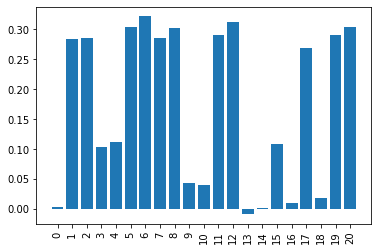

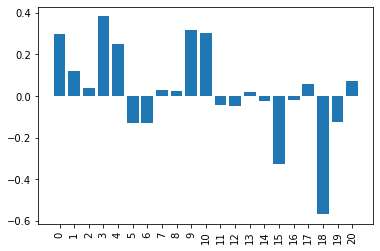

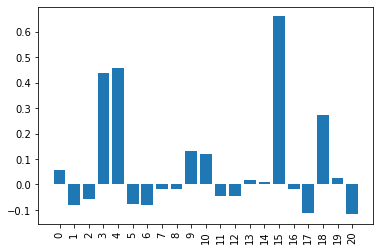

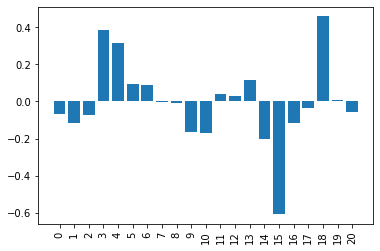

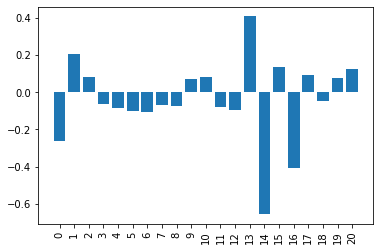

In [18]:
mealData = pd.read_csv('MealFeatures.csv')
noMealData = pd.read_csv('NoMealFeatures.csv')

GeneratePCA(mealData, PCA_filename)
mealTransform = Transform(mealData, PCA_filename)
noMealTransform = Transform(noMealData, PCA_filename)

In [19]:
mealLabels = np.ones((mealTransform.shape[0], 1))
noMealLabels = np.zeros((noMealTransform.shape[0], 1))

mealDataWithLabels = np.concatenate((mealTransform, mealLabels), axis=1)
noMealDataWithLabels = np.concatenate((noMealTransform, noMealLabels), axis=1)

dataset = np.concatenate((mealDataWithLabels, noMealDataWithLabels), axis=0)
np.random.shuffle(dataset)

# Training Model

## SVM

In [20]:
class Classifiers:
    def __init__(self):
        return
    
    def genClassifier1(self):
        self.Classifier1 = SVC(kernel='rbf', gamma='auto')
#         self.Classifier1 = NuSVC(nu=0.9, kernel='rbf', gamma='auto')
        
    def trainClassifier1(self, train_data):
        self.genClassifier1()
        self.Classifier1.fit(train_data[:, :-1], train_data[:, -1])
        
    def validateClassifier1(self, test_data):
        labels = self.Classifier1.predict(test_data[:, :-1])
        return labels
    
    def loadClassifier1(self, filename):
        return
        
    def saveClassifier1(self, filename):
        return

In [21]:
def evaluate(test_labels, labels):
    TP = 0.0
    FP = 0.0
    TN = 0.0
    FN = 0.0
    base = len(labels)
    for i in range(len(labels)):
        if labels[i] == 1:
            if test_labels[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if test_labels[i] == 0:
                TN += 1
            else:
                FN += 1
    acc = (TP+TN)/base
    prec = (TP)/(TP+FP)
    rec = (TP)/(TP+FN)
    return acc, prec, rec

In [22]:
no_k = 5
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
models = Classifiers()
for train, test in kf.split(dataset):
    models.trainClassifier1(dataset[train])
    labels = models.validateClassifier1(dataset[test])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))

Acc = 0.750000, Prec = 0.707692, Rec = 0.901961, F1 = 0.793103
Acc = 0.687500, Prec = 0.650000, Rec = 0.812500, F1 = 0.722222
Acc = 0.625000, Prec = 0.606557, Rec = 0.755102, F1 = 0.672727
Acc = 0.666667, Prec = 0.650000, Rec = 0.780000, F1 = 0.709091
Acc = 0.789474, Prec = 0.732143, Rec = 0.891304, F1 = 0.803922
MEAN: Acc = 0.703728, Prec = 0.669279, Rec = 0.828173, F1 = 0.740296


## Ensemble Classifier (Neural network- Multi-layer Perceptron AND Gaussian Process Classifier) -Vedant Salvi

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
no_k = 10
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
gpc = None
test_data=None
#models = Classifiers()
for train, test in kf.split(dataset):
    kernel = 1.0 * RBF(1.0)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)
    mlp = MLPClassifier(solver='lbfgs',activation ='tanh', alpha=1e-5,hidden_layer_sizes=(4,4), random_state=1)
    ensembleClassifier = VotingClassifier(estimators=[('gpc', gpc), ('mlp', mlp)],voting='soft')
    ensembleClassifier = ensembleClassifier.fit(dataset[train][:, :-1], dataset[train][:, -1])
    #gpc.score(dataset[train][:, :-1], dataset[train][:, -1])
    labels = ensembleClassifier.predict(dataset[test][:, :-1])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    test_data=dataset[test]
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))

Acc = 0.812500, Prec = 0.863636, Rec = 0.760000, F1 = 0.808511
Acc = 0.729167, Prec = 0.709677, Rec = 0.846154, F1 = 0.771930
Acc = 0.854167, Prec = 0.827586, Rec = 0.923077, F1 = 0.872727
Acc = 0.750000, Prec = 0.666667, Rec = 0.909091, F1 = 0.769231
Acc = 0.750000, Prec = 0.676471, Rec = 0.958333, F1 = 0.793103
Acc = 0.708333, Prec = 0.720000, Rec = 0.720000, F1 = 0.720000
Acc = 0.687500, Prec = 0.724138, Rec = 0.750000, F1 = 0.736842
Acc = 0.895833, Prec = 0.869565, Rec = 0.909091, F1 = 0.888889
Acc = 0.812500, Prec = 0.769231, Rec = 0.869565, F1 = 0.816327
Acc = 0.893617, Prec = 0.846154, Rec = 0.956522, F1 = 0.897959
MEAN: Acc = 0.789362, Prec = 0.767313, Rec = 0.860183, F1 = 0.811098


In [25]:
joblib.dump(ensembleClassifier, 'gpc.pkl') 
gpc_from_joblib = joblib.load('gpc.pkl')  
labels = gpc_from_joblib.predict(dataset[test][:, :-1]) 
acc, prec, rec = evaluate(dataset[test][:, -1], labels)
total_acc += acc
total_prec += prec
total_rec += rec
test_data=dataset[test]
print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))


Acc = 0.893617, Prec = 0.846154, Rec = 0.956522, F1 = 0.897959
MEAN: Acc = 0.878723, Prec = 0.851928, Rec = 0.955835, F1 = 0.900895


# Voting Classifier (Omkar Muglikar)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomTreesEmbedding,VotingClassifier





no_k = 5
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
gpc = None
test_data=None
#models = Classifiers()
for train, test in kf.split(dataset):
    rf1 = RandomForestClassifier(n_estimators=50, max_depth=6,random_state=0)#.fit(dataset[train][:, :-1], dataset[train][:, -1])
    rf2 = AdaBoostClassifier(n_estimators=50, random_state=0)#.fit(dataset[train][:, :-1], dataset[train][:, -1])
    kernel = 1.0 * RBF(1.0)
    rf3 = GaussianProcessClassifier(kernel=kernel,random_state=0)#.fit(dataset[train][:, :-1], dataset[train][:, -1])
    rf4 = SVC(kernel='rbf', gamma='auto')#.fit(dataset[train][:, :-1], dataset[train][:, -1])
    
    
    vclf = VotingClassifier(estimators=[('rf', rf1), ('ab', rf2), ('gpc', rf3), ('svm',rf4)], voting='hard', weights=[2,0.9,0.5,0.3])
    vclf.fit(dataset[train][:, :-1], dataset[train][:, -1])
    
    
    vclf.score(dataset[train][:, :-1], dataset[train][:, -1])
    labels = vclf.predict(dataset[test][:, :-1])
    
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    test_data=dataset[test]
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))



Acc = 0.822917, Prec = 0.774194, Rec = 0.941176, F1 = 0.849558
Acc = 0.739583, Prec = 0.701754, Rec = 0.833333, F1 = 0.761905
Acc = 0.760417, Prec = 0.724138, Rec = 0.857143, F1 = 0.785047
Acc = 0.791667, Prec = 0.750000, Rec = 0.900000, F1 = 0.818182
Acc = 0.789474, Prec = 0.750000, Rec = 0.847826, F1 = 0.795918
MEAN: Acc = 0.780811, Prec = 0.740017, Rec = 0.875896, F1 = 0.802244


In [27]:
joblib.dump(vclf, 'vclf.pkl') 





['vclf.pkl']

In [28]:
no_k = 5
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
gpc = None
test_data=None
vclf_from_joblib = joblib.load('vclf.pkl')

for train, test in kf.split(dataset):

    labels = vclf_from_joblib.predict(dataset[test][:, :-1]) 
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    test_data=dataset[test]
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))




Acc = 0.927083, Prec = 0.879310, Rec = 1.000000, F1 = 0.935780
Acc = 0.906250, Prec = 0.867925, Rec = 0.958333, F1 = 0.910891
Acc = 0.854167, Prec = 0.786885, Rec = 0.979592, F1 = 0.872727
Acc = 0.875000, Prec = 0.816667, Rec = 0.980000, F1 = 0.890909
Acc = 0.789474, Prec = 0.750000, Rec = 0.847826, F1 = 0.795918
MEAN: Acc = 0.870395, Prec = 0.820157, Rec = 0.953150, F1 = 0.881667


In [29]:
dataset[train][:, :-1].shape

(384, 5)

In [30]:
dataset[test][:, -1].shape

(95,)

# Naive Bayes Decision Tree


In [34]:
no_k = 5
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
models = Classifiers()
for train, test in kf.split(dataset):
    dt=DecisionTreeClassifier(max_depth=5)
    gnb=GaussianNB()
    ensembleClassifier = VotingClassifier(estimators=[('dt',dt), ('gnb',gnb)],voting='soft')
    ensembleClassifier = ensembleClassifier.fit(dataset[train][:, :-1], dataset[train][:, -1])
    labels = ensembleClassifier.predict(dataset[test][:, :-1])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))


Acc = 0.718750, Prec = 0.671429, Rec = 0.921569, F1 = 0.776860
Acc = 0.697917, Prec = 0.650794, Rec = 0.854167, F1 = 0.738739
Acc = 0.697917, Prec = 0.661290, Rec = 0.836735, F1 = 0.738739
Acc = 0.750000, Prec = 0.691176, Rec = 0.940000, F1 = 0.796610
Acc = 0.789474, Prec = 0.724138, Rec = 0.913043, F1 = 0.807692
MEAN: Acc = 0.730811, Prec = 0.679765, Rec = 0.893103, F1 = 0.771966
